In [1]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm
from PIL import Image
from PIL import ImageDraw, ImageFont
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
from datasets import load_dataset 
from datasets import load_metric
from datasets.features import ClassLabel
from transformers.data.data_collator import default_data_collator
from transformers import AutoProcessor
from transformers import LayoutLMv3ForTokenClassification
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForTokenClassification
from transformers.integrations import TensorBoardCallback
import accelerate
DIR = os.getcwd()


In [5]:
!nvidia-smi

Sat May  6 18:38:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   62C    P8    14W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
torch.__version__

'2.0.0+cpu'

In [3]:
torch.cuda.is_available()

False

In [3]:
!git config --global user.email "andre002wp@gmail.com"
!git config --global user.name "andre002wp"

In [4]:
dataset = load_dataset("Theivaprakasham/wildreceipt")
example = dataset["train"][0]
example["image_path"]
words, bboxes, ner_tags = example["words"], example["bboxes"], example["ner_tags"]
print(words)
print(bboxes)
print(ner_tags)

Found cached dataset wildreceipt (C:/Users/asus/.cache/huggingface/datasets/Theivaprakasham___wildreceipt/WildReceipt/1.0.0/643cda6d4cd0ff2e8d7ee57e4872c509b29060f1df957b5a59e66d9940b9594e)


  0%|          | 0/2 [00:00<?, ?it/s]

['SAFEWAY', 'TM', 'ATOREMGRTOMMILAZZO', '703-777-5833', 'THANKYOUFORSHOPPINGWITHUS!', 'GROCERY', 'BCCHOCCUPCAKES', 'ACNSPRYFRTSHAPE', 'Regprice', 'Cardsavings', 'MfrCpn', 'MultipliedCpn', 'DULCEDELECHECHE', 'Regprice', 'CardSavings', 'MfrCpn', 'MuitipliedCpn', 'MULTIGRAINCHEERIO', 'RegPrice', 'CardSavings', 'MfrCpn', 'MuitieliedCpn', 'PROGRESSOR&HSTK', 'RegPrice', 'CardSavings', 'REFRIG/FROZEN', '3.99', '.49', '3.79', '1.80-', '.75-', '.75-', '1.99', '4.19', '1.20-', '.50-', '.50-', '1.50', '3.99', '1.49-', '.50-', '.50-', '2.00', '2.69', '.69-', '1OIY', 'PLSBRYBSCTSANDWI', 'TOTINOSPZASTOFFE', 'RegPrice', '', '', '3.50', '3.49', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
[[343, 86, 585, 158], [655, 163, 671, 175], [334, 166, 520, 199], [566, 185, 675, 213], [360, 191, 635, 235], [452, 295, 525, 322], [296, 328, 458, 360], [293, 350, 477, 388], [291, 373, 371, 402], [289, 398, 411, 430], [286, 422, 358, 448], [284, 446, 428, 481], [283, 470, 468, 509], [280, 494, 363, 520], [278, 519, 402, 551]

## Exploration

In [3]:
dataset["train"]

Dataset({
    features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
    num_rows: 1267
})

In [4]:
dataset["test"]

Dataset({
    features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
    num_rows: 472
})

## random test

In [5]:
def normalize_bbox(bbox, size):
    return [
        int(bbox[0] * 1000 / size[1]),
        int(bbox[1] * 1000 / size[0]),
        int(bbox[2] * 1000 / size[1]),
        int(bbox[3] * 1000 / size[0]),
    ]

def unnormalize_bbox(bbox, size):
     return [
        int(bbox[0] * size[1] / 1000),
        int(bbox[1] * size[0] / 1000),
        int(bbox[2] * size[1] / 1000),
        int(bbox[3] * size[0] / 1000),
    ]


def fix_box(bbox, size):
    return [
        int(bbox[0] * size[1] / 1000),
        int(bbox[1] * size[0] / 1000),
        int(bbox[2] * size[1] / 1000),
        int(bbox[3] * size[0] / 1000),
    ]

label2color = {
    "Date_key": 'red',
    "Date_value": 'blue',
    "Ignore": 'orange',
    "Others": 'orange',
    "Prod_item_key": 'red',
    "Prod_item_value": 'green',
    "Prod_price_key": 'red',
    "Prod_price_value": 'blue',
    "Prod_quantity_key": 'red',
    "Prod_quantity_value": 'green',
    "Store_addr_key": 'red',
    "Store_addr_value": 'blue',
    "Store_name_key": 'red',
    "Store_name_value": 'blue',
    "Subtotal_key": 'red',
    "Subtotal_value": 'blue',
    "Tax_key": 'red',
    "Tax_value": 'green',
    "Tel_key": 'red',
    "Tel_value": 'green',
    "Time_key": 'red',
    "Time_value": 'green',
    "Tips_key": 'red',
    "Tips_value": 'green',
    "Total_key": 'red',
    "Total_value": 'blue'
  }

In [6]:
unique_ner_tags = set()
on_list = []
for example in dataset["train"]:
    for ner_tag in example["ner_tags"]:
        if ner_tag not in unique_ner_tags:
            print(ner_tag," on ",example["id"])
            on_list.append(example["image_path"])
            unique_ner_tags.add(ner_tag)
unique_ner_tags

1  on  0
25  on  0
5  on  0
11  on  0
15  on  0
14  on  0
0  on  0
3  on  1
18  on  1
20  on  1
24  on  1
17  on  1
19  on  1
23  on  1
7  on  1
9  on  1
13  on  2
22  on  5
21  on  5
12  on  7
8  on  7
6  on  8
10  on  10
16  on  10
2  on  71
4  on  386


{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25}

In [7]:
on_list = list(set(on_list))
on_list

['C:\\Users\\asus\\.cache\\huggingface\\datasets\\downloads\\extracted\\fed58dc3b18e734a659061bf972b2f62107167b090962f4aa1c34eedbbff1719\\wildreceipt\\image_files\\Image_44\\17\\d7569862ce517a0518b889065f2bc7053a9bd6cd.jpeg',
 'C:\\Users\\asus\\.cache\\huggingface\\datasets\\downloads\\extracted\\fed58dc3b18e734a659061bf972b2f62107167b090962f4aa1c34eedbbff1719\\wildreceipt\\image_files\\Image_36\\15\\f4bb5ce76d2bc39f560fade5d3bc8aee9edaee6a.jpeg',
 'C:\\Users\\asus\\.cache\\huggingface\\datasets\\downloads\\extracted\\fed58dc3b18e734a659061bf972b2f62107167b090962f4aa1c34eedbbff1719\\wildreceipt\\image_files\\Image_61\\3\\209ed5a9c073c6a401a74be946e06b90b64f6244.jpeg',
 'C:\\Users\\asus\\.cache\\huggingface\\datasets\\downloads\\extracted\\fed58dc3b18e734a659061bf972b2f62107167b090962f4aa1c34eedbbff1719\\wildreceipt\\image_files\\Image_18\\12\\1bf58322901e12bd7a7b943078b20e5aa931b28a.jpeg',
 'C:\\Users\\asus\\.cache\\huggingface\\datasets\\downloads\\extracted\\fed58dc3b18e734a659061bf9

In [14]:
test_img = Image.open(on_list[8])
test_box = [unnormalize_bbox(box, (test_img.size[1],test_img.size[0])) for box in example["bboxes"]]

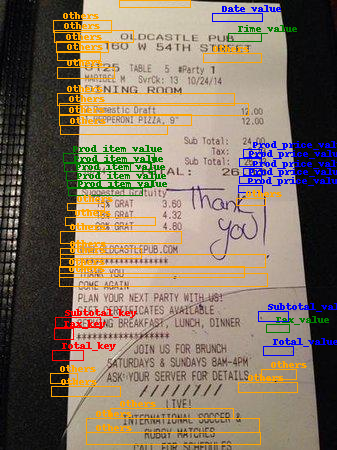

In [15]:
draw = ImageDraw.Draw(test_img)
font = ImageFont.load_default()
labels = {k: v for k,v in enumerate(dataset["train"].features["ner_tags"].feature.names)}

for tag, box in zip(example["ner_tags"], test_box):
    image_labels = labels[tag]
    draw.rectangle(box, outline=label2color[image_labels])
    draw.text((box[0]+10, box[1]-10), text=image_labels, fill=label2color[image_labels], font=font)
test_img

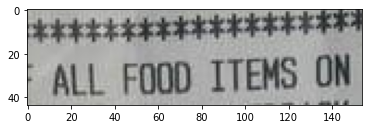

(1000, 562, 3)


[202, 191, 356, 235]

In [16]:
img_read = cv2.imread(example["image_path"])
img_read = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
if img_read is None:
    raise Exception(f"Image {example['image_path']} not found")

xx = [360, 191, 635, 235]
xx = unnormalize_bbox(xx, img_read.shape)
plt.imshow(img_read[xx[1]:xx[3],xx[0]:xx[2]])
plt.show()
print(img_read.shape)
xx

## Continue

In [6]:
label_primary_names = ['Ignore',
                    'Store_name_value',
                    'Store_name_key',
                    'Store_addr_value',
                    'Store_addr_key',
                    'Tel_value',
                    'Tel_key',
                    'Date_value',
                    'Date_key',
                    'Time_value',
                    'Time_key',
                    'Prod_item_value',
                    'Prod_item_key',
                    'Prod_quantity_value',
                    'Prod_quantity_key',
                    'Prod_price_value',
                    'Prod_price_key',
                    'Subtotal_value',
                    'Subtotal_key',
                    'Tax_value',
                    'Tax_key',
                    'Tips_value',
                    'Tips_key',
                    'Total_value',
                    'Total_key',
                    'Others']

In [7]:
label_new_names = ['Ignore', 
                    'Store_name_value',
                    'Date_value',
                    'Time_value',
                    'Prod_item_key',
                    'Prod_item_value',
                    'Prod_quantity_key',
                    'Prod_quantity_value',
                    'Prod_price_key',
                    'Prod_price_value',
                    'Subtotal_key',
                    'Subtotal_value',
                    'Total_key',
                    'Total_value',
                    'Others']

In [8]:
excluded_labels = [tag for tag in label_primary_names if tag not in label_new_names]

In [9]:
features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image_path"

def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

label_list = label_new_names
id2label = {k: v for k,v in enumerate(label_list)}
label2id = {v: k for k,v in enumerate(label_list)}
id2label

{0: 'Ignore',
 1: 'Store_name_value',
 2: 'Date_value',
 3: 'Time_value',
 4: 'Prod_item_key',
 5: 'Prod_item_value',
 6: 'Prod_quantity_key',
 7: 'Prod_quantity_value',
 8: 'Prod_price_key',
 9: 'Prod_price_value',
 10: 'Subtotal_key',
 11: 'Subtotal_value',
 12: 'Total_key',
 13: 'Total_value',
 14: 'Others'}

In [10]:
from datasets import Dataset
new_train_data = []
new_test_data = []

In [11]:
# Secondary Dataset
for example in dataset["train"]:
    new_ner_tags = [label_primary_names[tag] for tag in example["ner_tags"]]
    new_ner_tags = [label2id[tag] if tag not in excluded_labels else 14 for tag in new_ner_tags]
    new_train_data.append({"id": example["id"],"words": example["words"], "bboxes": example["bboxes"], "ner_tags": new_ner_tags, "image_path": example["image_path"]})


In [12]:
# Main Dataset
cur_ids = len(new_train_data)
for item in os.listdir("Final Dataset/Train"):
    basename = os.path.splitext(item)[0]
    with open(os.path.join("Annotation",basename+".json")) as f:
        data = json.load(f)
        path = os.path.join("Final Dataset","Train",item)
        new_train_data.append({"id": str(cur_ids),"words": data["words"], "bboxes": data["bboxes"], "ner_tags": data['labels'], "image_path": path})
        cur_ids += 1
cur_ids

1348

In [13]:
# Secondary Dataset
for example in dataset["test"]:
    new_ner_tags = [label_primary_names[tag] for tag in example["ner_tags"]]
    new_ner_tags = [label2id[tag] if tag not in excluded_labels else 14 for tag in new_ner_tags]
    new_test_data.append({"id": example["id"],"words": example["words"], "bboxes": example["bboxes"], "ner_tags": new_ner_tags, "image_path": example["image_path"]})

In [14]:
# Main Dataset
cur_ids = len(new_test_data)
for item in os.listdir("Final Dataset/Test"):
    basename = os.path.splitext(item)[0]
    with open(os.path.join("Annotation",basename+".json")) as f:
        data = json.load(f)
        path = os.path.join("Final Dataset","Test",item)
        new_test_data.append({"id": str(cur_ids),"words": data["words"], "bboxes": data["bboxes"], "ner_tags": data['labels'], "image_path": path})
        cur_ids += 1
cur_ids

492

In [15]:
new_train_data = Dataset.from_list(new_train_data)
new_test_data = Dataset.from_list(new_test_data)

### Checking For Problems

In [16]:
for item in os.listdir("Annotation"):
    with open(os.path.join("Annotation",item)) as f:
        data = json.load(f)
        for boxes in data["bboxes"]:
            if boxes[0] >= 1000 or boxes[1] >= 1000 or boxes[2] >= 1000 or boxes[3] >= 1000 or boxes[0] <= 0 or boxes[1] <= 0 or boxes[2] <= 0 or boxes[3] <= 0:
                print(item)
                print(boxes)

In [29]:
dataset["train"]

Dataset({
    features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
    num_rows: 1267
})

In [30]:
new_train_data

Dataset({
    features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
    num_rows: 1348
})

In [31]:
for example in new_train_data:
    print(example["ner_tags"])
    break

[1, 14, 14, 14, 14, 14, 5, 5, 14, 14, 14, 14, 5, 14, 14, 14, 14, 5, 14, 14, 14, 14, 5, 14, 14, 14, 9, 9, 14, 14, 14, 14, 9, 14, 14, 14, 14, 9, 14, 14, 14, 14, 9, 14, 14, 6, 5, 5, 14, 0, 0, 9, 9, 14, 14, 14, 14, 14, 14, 14]


### Auto Processor

In [17]:
# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [18]:
def prepare_examples(examples):
  images = [Image.open(path).convert("RGB") for path in examples['image_path']] #Image.open(examples[image_column_name])
  words = examples["words"]
  boxes = examples["bboxes"]
  word_labels = examples["ner_tags"]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [19]:
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(ClassLabel(names=label_list)),
})

train_dataset = new_train_data.map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = new_test_data.map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [20]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> SAFEWAY TM ATOREMGRTOMMILAZZO 703-777-5833 THANKYOUFORSHOPPINGWITHUS! GROCERY BCCHOCCUPCAKES ACNSPRYFRTSHAPE Regprice Cardsavings MfrCpn MultipliedCpn DULCEDELECHECHE Regprice CardSavings MfrCpn MuitipliedCpn MULTIGRAINCHEERIO RegPrice CardSavings MfrCpn MuitieliedCpn PROGRESSOR&HSTK RegPrice CardSavings REFRIG/FROZEN 3.99.49 3.79 1.80-.75-.75- 1.99 4.19 1.20-.50-.50- 1.50 3.99 1.49-.50-.50- 2.00 2.69.69- 1OIY PLSBRYBSCTSANDWI TOTINOSPZASTOFFE RegPrice 3.50 3.49 B B B B B B B</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [20]:
train_dataset.set_format("torch")
eval_dataset.set_format("torch")

In [37]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [21]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 1348
})

In [22]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 492
})

In [40]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

'<s> CHOEUN KOREANRESTAURANT 2621ORANGETHORPEAVE,FULLERTON. (714)879-3574 THANKYOU!! DATE 12/30/2016FRI 19:19 BIBIM.OCTOPUT1 S-FOODP.CAKT1 PORKDUMPLINT1 LABEEFRIBT1 $13.99 $14.99 $8.99 ￥17.99 4.00xITEMS SUBTOTAL TAX1 TOTAL $55.96 $4.48 $60.44 TIME</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [23]:
return_entity_level_metrics = False
metric = load_metric("seqeval")


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

C:\Users\asus\AppData\Local\Temp\ipykernel_70840\1621203644.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [ ]:
#save autoprocessor to use in inference
# processor.save_pretrained(os.path.join("Saved_model","Processor","all_data_4epochs"))

In [24]:
model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
# training_args = TrainingArguments(output_dir="Training_logs",
#                                   max_steps=5000,
#                                   per_device_train_batch_size=5,
#                                   per_device_eval_batch_size=5,
#                                   learning_rate=1e-5,
#                                   evaluation_strategy="steps",
#                                   save_strategy="steps",
#                                   load_best_model_at_end=True,
#                                   metric_for_best_model="f1",
#                                   report_to="tensorboard",
#                                   )
training_args = TrainingArguments(output_dir="Training_logs/track_traininglogs2",
                                  num_train_epochs=10,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  )

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [57]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
    callbacks=[TensorBoardCallback()],
)

You are adding a <class 'transformers.integrations.TensorBoardCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback


In [48]:
%tensorboard --logdir Training_logs/track_traininglogs
# 1.13.1+cu117

UsageError: Line magic function `%tensorboard` not found.


In [58]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [59]:
trainer.train()

***** Running training *****
  Num examples = 1348
  Num Epochs = 10
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 6740
  Number of trainable parameters = 125929103


  0%|          | 0/6740 [00:00<?, ?it/s]

{'loss': 0.2725, 'learning_rate': 4.6290801186943624e-05, 'epoch': 0.74}


***** Running Evaluation *****
  Num examples = 492
  Batch size = 2


  0%|          | 0/246 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Time_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:1

{'eval_loss': 0.274355947971344, 'eval_precision': 0.813328619409581, 'eval_recall': 0.8288596649252387, 'eval_f1': 0.8210206995003568, 'eval_accuracy': 0.9193732335002727, 'eval_runtime': 51.3087, 'eval_samples_per_second': 9.589, 'eval_steps_per_second': 4.795, 'epoch': 1.0}


Model weights saved in Training_logs/track_traininglogs2\checkpoint-674\pytorch_model.bin
Image processor saved in Training_logs/track_traininglogs2\checkpoint-674\preprocessor_config.json
tokenizer config file saved in Training_logs/track_traininglogs2\checkpoint-674\tokenizer_config.json
Special tokens file saved in Training_logs/track_traininglogs2\checkpoint-674\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.2148, 'learning_rate': 4.258160237388724e-05, 'epoch': 1.48}


***** Running Evaluation *****
  Num examples = 492
  Batch size = 2


  0%|          | 0/246 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Time_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:1

{'eval_loss': 0.2655044198036194, 'eval_precision': 0.8176143074067825, 'eval_recall': 0.872995856602414, 'eval_f1': 0.8443979787419411, 'eval_accuracy': 0.9254227202856151, 'eval_runtime': 53.9465, 'eval_samples_per_second': 9.12, 'eval_steps_per_second': 4.56, 'epoch': 2.0}


Model weights saved in Training_logs/track_traininglogs2\checkpoint-1348\pytorch_model.bin
Image processor saved in Training_logs/track_traininglogs2\checkpoint-1348\preprocessor_config.json
tokenizer config file saved in Training_logs/track_traininglogs2\checkpoint-1348\tokenizer_config.json
Special tokens file saved in Training_logs/track_traininglogs2\checkpoint-1348\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.1893, 'learning_rate': 3.887240356083086e-05, 'epoch': 2.23}
{'loss': 0.1636, 'learning_rate': 3.516320474777448e-05, 'epoch': 2.97}


***** Running Evaluation *****
  Num examples = 492
  Batch size = 2


  0%|          | 0/246 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Time_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:1

{'eval_loss': 0.24321159720420837, 'eval_precision': 0.8475685234305924, 'eval_recall': 0.8634480273824536, 'eval_f1': 0.855434588613243, 'eval_accuracy': 0.9355382555660237, 'eval_runtime': 51.5703, 'eval_samples_per_second': 9.54, 'eval_steps_per_second': 4.77, 'epoch': 3.0}


Model weights saved in Training_logs/track_traininglogs2\checkpoint-2022\pytorch_model.bin
Image processor saved in Training_logs/track_traininglogs2\checkpoint-2022\preprocessor_config.json
tokenizer config file saved in Training_logs/track_traininglogs2\checkpoint-2022\tokenizer_config.json
Special tokens file saved in Training_logs/track_traininglogs2\checkpoint-2022\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.1213, 'learning_rate': 3.14540059347181e-05, 'epoch': 3.71}


***** Running Evaluation *****
  Num examples = 492
  Batch size = 2


  0%|          | 0/246 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Time_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:1

{'eval_loss': 0.2377520352602005, 'eval_precision': 0.8779685787358421, 'eval_recall': 0.8657899477571609, 'eval_f1': 0.8718367346938775, 'eval_accuracy': 0.9423811176674766, 'eval_runtime': 51.4258, 'eval_samples_per_second': 9.567, 'eval_steps_per_second': 4.784, 'epoch': 4.0}


Model weights saved in Training_logs/track_traininglogs2\checkpoint-2696\pytorch_model.bin
Image processor saved in Training_logs/track_traininglogs2\checkpoint-2696\preprocessor_config.json
tokenizer config file saved in Training_logs/track_traininglogs2\checkpoint-2696\tokenizer_config.json
Special tokens file saved in Training_logs/track_traininglogs2\checkpoint-2696\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.1037, 'learning_rate': 2.774480712166172e-05, 'epoch': 4.45}


***** Running Evaluation *****
  Num examples = 492
  Batch size = 2


  0%|          | 0/246 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Time_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:1

{'eval_loss': 0.24678122997283936, 'eval_precision': 0.8838958180484225, 'eval_recall': 0.8681318681318682, 'eval_f1': 0.8759429246569117, 'eval_accuracy': 0.9453562751028909, 'eval_runtime': 51.6451, 'eval_samples_per_second': 9.527, 'eval_steps_per_second': 4.763, 'epoch': 5.0}


Model weights saved in Training_logs/track_traininglogs2\checkpoint-3370\pytorch_model.bin
Image processor saved in Training_logs/track_traininglogs2\checkpoint-3370\preprocessor_config.json
tokenizer config file saved in Training_logs/track_traininglogs2\checkpoint-3370\tokenizer_config.json
Special tokens file saved in Training_logs/track_traininglogs2\checkpoint-3370\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0883, 'learning_rate': 2.4035608308605344e-05, 'epoch': 5.19}
{'loss': 0.0719, 'learning_rate': 2.0326409495548962e-05, 'epoch': 5.93}


***** Running Evaluation *****
  Num examples = 492
  Batch size = 2


  0%|          | 0/246 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Time_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:1

{'eval_loss': 0.25186285376548767, 'eval_precision': 0.8763923823212361, 'eval_recall': 0.8787605836786164, 'eval_f1': 0.8775748853107853, 'eval_accuracy': 0.9464967521197997, 'eval_runtime': 52.0267, 'eval_samples_per_second': 9.457, 'eval_steps_per_second': 4.728, 'epoch': 6.0}


Model weights saved in Training_logs/track_traininglogs2\checkpoint-4044\pytorch_model.bin
Image processor saved in Training_logs/track_traininglogs2\checkpoint-4044\preprocessor_config.json
tokenizer config file saved in Training_logs/track_traininglogs2\checkpoint-4044\tokenizer_config.json
Special tokens file saved in Training_logs/track_traininglogs2\checkpoint-4044\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0544, 'learning_rate': 1.661721068249258e-05, 'epoch': 6.68}


***** Running Evaluation *****
  Num examples = 492
  Batch size = 2


  0%|          | 0/246 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Time_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:1

{'eval_loss': 0.28478360176086426, 'eval_precision': 0.8827798947559427, 'eval_recall': 0.8764186633039092, 'eval_f1': 0.8795877779786657, 'eval_accuracy': 0.9474388853076808, 'eval_runtime': 54.3002, 'eval_samples_per_second': 9.061, 'eval_steps_per_second': 4.53, 'epoch': 7.0}


Model weights saved in Training_logs/track_traininglogs2\checkpoint-4718\pytorch_model.bin
Image processor saved in Training_logs/track_traininglogs2\checkpoint-4718\preprocessor_config.json
tokenizer config file saved in Training_logs/track_traininglogs2\checkpoint-4718\tokenizer_config.json
Special tokens file saved in Training_logs/track_traininglogs2\checkpoint-4718\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0438, 'learning_rate': 1.29080118694362e-05, 'epoch': 7.42}


***** Running Evaluation *****
  Num examples = 492
  Batch size = 2


  0%|          | 0/246 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Time_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:1

{'eval_loss': 0.32215407490730286, 'eval_precision': 0.8882998171846435, 'eval_recall': 0.8753377769771212, 'eval_f1': 0.8817711641411848, 'eval_accuracy': 0.9470421976496256, 'eval_runtime': 55.4406, 'eval_samples_per_second': 8.874, 'eval_steps_per_second': 4.437, 'epoch': 8.0}


Model weights saved in Training_logs/track_traininglogs2\checkpoint-5392\pytorch_model.bin
Image processor saved in Training_logs/track_traininglogs2\checkpoint-5392\preprocessor_config.json
tokenizer config file saved in Training_logs/track_traininglogs2\checkpoint-5392\tokenizer_config.json
Special tokens file saved in Training_logs/track_traininglogs2\checkpoint-5392\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0373, 'learning_rate': 9.198813056379822e-06, 'epoch': 8.16}
{'loss': 0.0238, 'learning_rate': 5.489614243323442e-06, 'epoch': 8.9}


***** Running Evaluation *****
  Num examples = 492
  Batch size = 2


  0%|          | 0/246 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Time_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:1

{'eval_loss': 0.34144094586372375, 'eval_precision': 0.8869199853854586, 'eval_recall': 0.874617186092596, 'eval_f1': 0.8807256235827665, 'eval_accuracy': 0.9469430257351118, 'eval_runtime': 53.4527, 'eval_samples_per_second': 9.204, 'eval_steps_per_second': 4.602, 'epoch': 9.0}


Model weights saved in Training_logs/track_traininglogs2\checkpoint-6066\pytorch_model.bin
Image processor saved in Training_logs/track_traininglogs2\checkpoint-6066\preprocessor_config.json
tokenizer config file saved in Training_logs/track_traininglogs2\checkpoint-6066\tokenizer_config.json
Special tokens file saved in Training_logs/track_traininglogs2\checkpoint-6066\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.021, 'learning_rate': 1.7804154302670625e-06, 'epoch': 9.64}


***** Running Evaluation *****
  Num examples = 492
  Batch size = 2


  0%|          | 0/246 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Time_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:1

{'eval_loss': 0.34971514344215393, 'eval_precision': 0.8872029250457039, 'eval_recall': 0.8742568906503333, 'eval_f1': 0.880682333726522, 'eval_accuracy': 0.9470917836068825, 'eval_runtime': 52.1983, 'eval_samples_per_second': 9.426, 'eval_steps_per_second': 4.713, 'epoch': 10.0}


Model weights saved in Training_logs/track_traininglogs2\checkpoint-6740\pytorch_model.bin
Image processor saved in Training_logs/track_traininglogs2\checkpoint-6740\preprocessor_config.json
tokenizer config file saved in Training_logs/track_traininglogs2\checkpoint-6740\tokenizer_config.json
Special tokens file saved in Training_logs/track_traininglogs2\checkpoint-6740\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from Training_logs/track_traininglogs2\checkpoint-5392 (score: 0.8817711641411848).


{'train_runtime': 4434.1328, 'train_samples_per_second': 3.04, 'train_steps_per_second': 1.52, 'train_loss': 0.10485957708839846, 'epoch': 10.0}


TrainOutput(global_step=6740, training_loss=0.10485957708839846, metrics={'train_runtime': 4434.1328, 'train_samples_per_second': 3.04, 'train_steps_per_second': 1.52, 'train_loss': 0.10485957708839846, 'epoch': 10.0})

In [61]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 492
  Batch size = 2
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


  0%|          | 0/246 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Time_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:1

{'eval_loss': 0.32215407490730286,
 'eval_precision': 0.8882998171846435,
 'eval_recall': 0.8753377769771212,
 'eval_f1': 0.8817711641411848,
 'eval_accuracy': 0.9470421976496256,
 'eval_runtime': 49.9032,
 'eval_samples_per_second': 9.859,
 'eval_steps_per_second': 4.93,
 'epoch': 10.0}

In [62]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 492
})

In [71]:
trainer.save_model("Saved_model/wut")

Saving model checkpoint to Saved_model/wut
Configuration saved in Saved_model/wut\config.json
Model weights saved in Saved_model/wut\pytorch_model.bin
Image processor saved in Saved_model/wut\preprocessor_config.json
tokenizer config file saved in Saved_model/wut\tokenizer_config.json
Special tokens file saved in Saved_model/wut\special_tokens_map.json


In [98]:
y_preds = []
y_trues = []
model.eval()
for idx,example in enumerate(eval_dataset):
    # if idx < 485:
    #     continue
    # print(idx)
    with torch.no_grad():
        encoding = {k: v.unsqueeze(0).to(device) for k, v in example.items()}
        outputs = model(**encoding)
        predictions = outputs.logits.argmax(-1).squeeze().tolist()

    y_trues.append([label[0] for label in zip(example["labels"].tolist(),predictions) if label[0] != -100])
    y_preds.append([label[1] for label in zip(example["labels"].tolist(),predictions) if label[0] != -100])

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [66]:
# processor.tokenizer.decode(eval_dataset[485]["input_ids"])

In [99]:
y_aktual = []
y_prediksi = []
for item in y_trues:
    y_aktual.extend(item)
for item in y_preds:
    y_prediksi.extend(item)

In [100]:
important_labels = [1,2,3,5,7,9,12,13,14]

In [101]:
y_aktual = [item if item in important_labels else 14 for item in y_aktual]
y_prediksi = [item if item in important_labels else 14 for item in y_prediksi]

In [102]:
id2label[2]

'Date_value'

              precision    recall  f1-score   support

           1     0.8835    0.8455    0.8641       628
           2     0.9830    0.9830    0.9830       470
           3     0.9550    0.9593    0.9571       442
           5     0.9625    0.9639    0.9632      2607
           7     0.9736    0.9636    0.9686      1568
           9     0.9748    0.9731    0.9740      2307
          12     0.8846    0.8984    0.8915       512
          13     0.8116    0.8945    0.8510       597
          14     0.9627    0.9602    0.9614     11036

    accuracy                         0.9559     20167
   macro avg     0.9324    0.9380    0.9349     20167
weighted avg     0.9563    0.9559    0.9560     20167



<AxesSubplot:title={'center':'Train Model 10epoch all data'}>

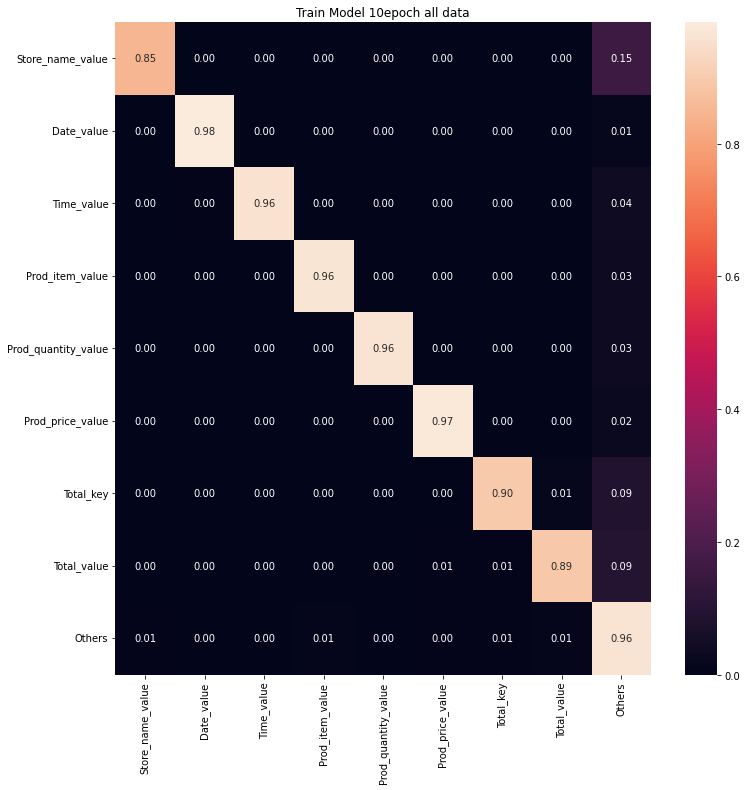

In [103]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

print(classification_report(y_aktual, y_prediksi, digits=4))

cm = confusion_matrix(y_aktual, y_prediksi)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12,12))
plt.title("Train Model 10epoch all data")
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=[id2label[it] for it in important_labels], yticklabels=[id2label[it] for it in important_labels])

In [328]:
# trainer.save_model("Saved_model/only_main_dataset_10epochs")

Saving model checkpoint to Saved_model/only_main_dataset_10epochs
Configuration saved in Saved_model/only_main_dataset_10epochs\config.json
Model weights saved in Saved_model/only_main_dataset_10epochs\pytorch_model.bin
Image processor saved in Saved_model/only_main_dataset_10epochs\preprocessor_config.json
tokenizer config file saved in Saved_model/only_main_dataset_10epochs\tokenizer_config.json
Special tokens file saved in Saved_model/only_main_dataset_10epochs\special_tokens_map.json


In [ ]:
# trainer.push_to_hub()

## Inference

In [64]:
model = AutoModelForTokenClassification.from_pretrained("Saved_model/all_data_4epochs")

In [ ]:
def fix_box(bbox, size):
    return [
        int(bbox[0] * size[1] / 1000),
        int(bbox[1] * size[0] / 1000),
        int(bbox[2] * size[1] / 1000),
        int(bbox[3] * size[0] / 1000),
    ]

In [137]:
with open(os.path.join(DIR,'Annotation','20230210_093933.json')) as f:
    data = json.load(f)


In [138]:
inf_path, inf_words, inf_bboxes = data['file_name'],data["words"], data["bboxes"]

In [139]:
images = cv2.imread(os.path.join(DIR,'Nota_Segmented','Batch 1',data['file_name']))
if images is None:
    images = cv2.imread(os.path.join(DIR,'Nota_Segmented','Batch 2',data['file_name']))

if images is None:
    raise Exception(f"File {data['file_name']} not found")

images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
# images = Image.open(os.path.join(DIR,'Nota_Segmented',inf_path)).convert("RGB") #Image.open(examples[image_column_name])
words = inf_words
boxes = inf_bboxes
encoding = processor(images, words, boxes=boxes, return_tensors="pt",truncation=True,padding=True)

for k,v in encoding.items():
  print(k,v.shape)

with torch.no_grad():
  outputs = model(**encoding)

logits = outputs.logits
print(logits.shape)

predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

input_ids torch.Size([1, 106])
attention_mask torch.Size([1, 106])
bbox torch.Size([1, 106, 4])
pixel_values torch.Size([1, 3, 224, 224])


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


torch.Size([1, 106, 15])
[14, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 3, 3, 3, 14, 14, 14, 14, 14, 5, 5, 5, 5, 5, 5, 7, 14, 14, 14, 14, 5, 5, 5, 5, 5, 5, 7, 14, 14, 14, 14, 5, 5, 5, 5, 5, 7, 14, 14, 14, 14, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 9, 9, 9, 9, 9, 9, 9, 9, 9, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14]


In [140]:
token_boxes = encoding.bbox.squeeze().tolist()

true_predictions = [model.config.id2label[pred] for pred in predictions]
true_boxes = [fix_box(box, images.shape) for box in token_boxes]

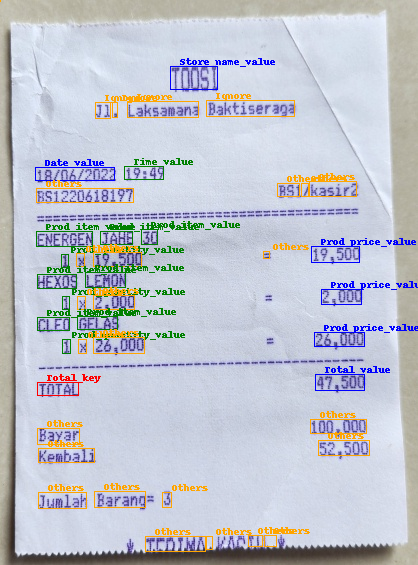

In [141]:
image_pil = Image.fromarray(images)
draw = ImageDraw.Draw(image_pil)

font = ImageFont.load_default()

def iob_to_label(label):
    #label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {
    "Date_key": 'red',
    "Date_value": 'blue',
    "Ignore": 'orange',
    "Others": 'orange',
    "Prod_item_key": 'red',
    "Prod_item_value": 'green',
    "Prod_price_key": 'red',
    "Prod_price_value": 'blue',
    "Prod_quantity_key": 'red',
    "Prod_quantity_value": 'green',
    "Store_addr_key": 'red',
    "Store_addr_value": 'blue',
    "Store_name_key": 'red',
    "Store_name_value": 'blue',
    "Subtotal_key": 'red',
    "Subtotal_value": 'blue',
    "Tax_key": 'red',
    "Tax_value": 'green',
    "Tel_key": 'red',
    "Tel_value": 'green',
    "Time_key": 'red',
    "Time_value": 'green',
    "Tips_key": 'red',
    "Tips_value": 'green',
    "Total_key": 'red',
    "Total_value": 'blue'
  }

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction)
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image_pil.save(os.path.join(DIR,'Result',inf_path))
image_pil

## Inference trial 2

In [9]:
processor = AutoProcessor.from_pretrained("Theivaprakasham/layoutlmv3-finetuned-wildreceipt", apply_ocr=False)

In [54]:
model = model = AutoModelForTokenClassification.from_pretrained("Saved_model/all_data_4epochs")

loading configuration file Saved_model/all_data_4epochs\config.json
Model config LayoutLMv3Config {
  "_name_or_path": "Saved_model/all_data_4epochs",
  "architectures": [
    "LayoutLMv3ForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Ignore",
    "1": "Store_name_value",
    "2": "Date_value",
    "3": "Time_value",
    "4": "Prod_item_key",
    "5": "Prod_item_value",
    "6": "Prod_quantity_key",
    "7": "Prod_quantity_value",
    "8": "Prod_price_key",
    "9": "Prod_price_value",
    "10": "Subtotal_key",
    "11": "Subtotal_value",
    "12": "Total_key",
    "13": "Total_value",
    "14": "Others"
  },
  "initializer_range": 0.02,
  "input_size": 224,
  "intermediate_size": 3072,
  "labe

In [55]:
# define id2label, label2color
labels = dataset['test'].features['ner_tags'].feature.names
id2label = {v: k for v, k in enumerate(labels)}
label2color = {
    "Date_key": 'red',
    "Date_value": 'blue',
    "Ignore": 'orange',
    "Others": 'orange',
    "Prod_item_key": 'red',
    "Prod_item_value": 'green',
    "Prod_price_key": 'red',
    "Prod_price_value": 'blue',
    "Prod_quantity_key": 'red',
    "Prod_quantity_value": 'green',
    "Store_addr_key": 'red',
    "Store_addr_value": 'blue',
    "Store_name_key": 'red',
    "Store_name_value": 'blue',
    "Subtotal_key": 'red',
    "Subtotal_value": 'blue',
    "Tax_key": 'red',
    "Tax_value": 'green',
    "Tel_key": 'red',
    "Tel_value": 'green',
    "Time_key": 'red',
    "Time_value": 'green',
    "Tips_key": 'red',
    "Tips_value": 'green',
    "Total_key": 'red',
    "Total_value": 'blue'
  }

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]


def iob_to_label(label):
    return label



def process_image(filepath):
    filename = filepath.split('/')[-1].split('//')[-1].split('\\')[-1]
    image = Image.open(filepath).convert("RGB")
    print(type(image))
    width, height = image.size

    with open(os.path.join(DIR,'annotation.json')) as f:
        data = json.load(f)

    inf_data = data[filename]
    inf_path, inf_words, inf_bboxes = inf_data['file_name'],inf_data["words"], inf_data["bboxes"]
    
    words = inf_words
    boxes = inf_bboxes

    # encode
    # encoding = processor(image, truncation=True, return_offsets_mapping=True, return_tensors="pt")
    encoding = processor(image, inf_words, boxes=inf_bboxes, return_tensors="pt",truncation=True,padding=True)

    # forward pass
    with torch.no_grad():
        outputs = model(**encoding)

    # get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()

    # only keep non-subword predictions
    true_predictions = [id2label[pred] for idx, pred in enumerate(predictions)]
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes)]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(true_predictions, true_boxes):
        predicted_label = iob_to_label(prediction)
        draw.rectangle(box, outline=label2color[predicted_label])
        draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)
        
    image.save(os.path.join(DIR,'Result',inf_path))
    return image

In [31]:
for filename in os.listdir('Nota_Segmented'):
    try:
        if filename != '20221013_194642.jpg':
            process_image(os.path.join('Nota_Segmented',filename))
    except:
        print(filename," has a problem")

<class 'PIL.Image.Image'>


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
20221013_192902.jpg  has a problem
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<cl